In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import torch.nn as nn
# Define the FastF1Dataset class
class FastF1Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx + self.sequence_length], dtype=torch.float32)

# Load your saved model
def load_model(model_path, model_class, sequence_length, input_dim, device):
    model = model_class(sequence_length, input_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Calculate reconstruction error
def compute_reconstruction_error(inputs, outputs):
    return torch.mean((inputs - outputs) ** 2, dim=1).detach().numpy()


# Define your autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, sequence_length, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(num_features, 64, batch_first=True)
        self.latent = nn.LSTM(64, 32, batch_first=True)
        self.decoder = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, num_features)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.latent(x[:, -1].unsqueeze(1).repeat(1, x.size(1), 1))
        x, _ = self.decoder(x)
        x = self.output_layer(x)
        return x

# Set paths and parameters
model_path = "AD_19-23_autoencoder_AdamW_lr0001_ep10_loss0.4037.pth"
new_data_path = "2024_LasVegasGrandPrix_GAS_MinMaxScaler_normalized_complete.npz"
sequence_length = 20
threshold = 500

# Load the new data
new_data = np.load(new_data_path, allow_pickle=True)['data']
new_data_array = np.array(new_data, dtype=np.float32)

# Create the test dataset and data loader
test_dataset = FastF1Dataset(new_data_array, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = new_data_array.shape[1]  # Number of features per timestep
autoencoder = load_model(model_path, LSTMAutoencoder, sequence_length, input_dim, device).to(device)

# Test the model
def test_autoencoder(autoencoder, data_loader, device):
    autoencoder.eval()
    errors = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.to(device)
            outputs = autoencoder(inputs)
            batch_errors = compute_reconstruction_error(inputs, outputs)
            errors.extend(batch_errors)

    return np.array(errors)

reconstruction_errors = test_autoencoder(autoencoder, test_loader, device)

# Set a threshold for anomalies


/var/folders/3k/39cgj5q54l52b9t9s6kj73kr0000gn/T/ipykernel_3203/1158925366.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

In [8]:
#new_data (npz) to pandas
import pandas as pd
pandassato = pd.DataFrame(new_data)

cols = [
       'Time_in_ms',
       'LapTime_in_ms',
       'LapNumber',
       'Position',
       'Speed',
       'AirTemp',
       'Humidity',
       'Pressure',
       'TrackTemp',
       'WindDirection',
       'WindSpeed',
       'DistanceToDriverAhead',
       'RPM',
       'nGear',
       'Throttle',
       'X', 
       'Y', 
       'Z', 
       'Distance', 
       'TyreLife',
       'Compound',
       'Team',
       'TrackStatus',
       'Rainfall',
       'DriverAhead',
       'Brake',
       'DRS',
       'Event'
    ]

pandassato.columns = cols
#first 50 rows of tyrelife
pandassato

,Time_in_ms,LapTime_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,DriverAhead,Brake,DRS,Event
0,0.003932,0.381304,0.0,0.0,0.008403,1.0,1.0,1.0,0.711111,1.000000,...,0.000000,0.000000,2.0,3.0,1.0,0.0,11.0,0.0,0.0,22.0
1,0.005778,0.381304,0.0,0.0,0.030812,1.0,1.0,1.0,0.711111,1.000000,...,0.000169,0.000000,2.0,3.0,1.0,0.0,81.0,0.0,0.0,22.0
2,0.006164,0.381304,0.0,0.0,0.039216,1.0,1.0,1.0,0.711111,1.000000,...,0.000211,0.000000,2.0,3.0,1.0,0.0,81.0,0.0,0.0,22.0
3,0.007881,0.381304,0.0,0.0,0.047619,1.0,1.0,1.0,0.711111,1.000000,...,0.000430,0.000000,2.0,3.0,1.0,0.0,81.0,0.0,0.0,22.0
4,0.008525,0.381304,0.0,0.0,0.058824,1.0,1.0,1.0,0.711111,1.000000,...,0.000530,0.000000,2.0,3.0,1.0,0.0,4.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11461,0.948928,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.996373,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11462,0.950980,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.997223,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11463,0.950988,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.997227,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11464,0.952525,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.997869,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0


<Axes: >

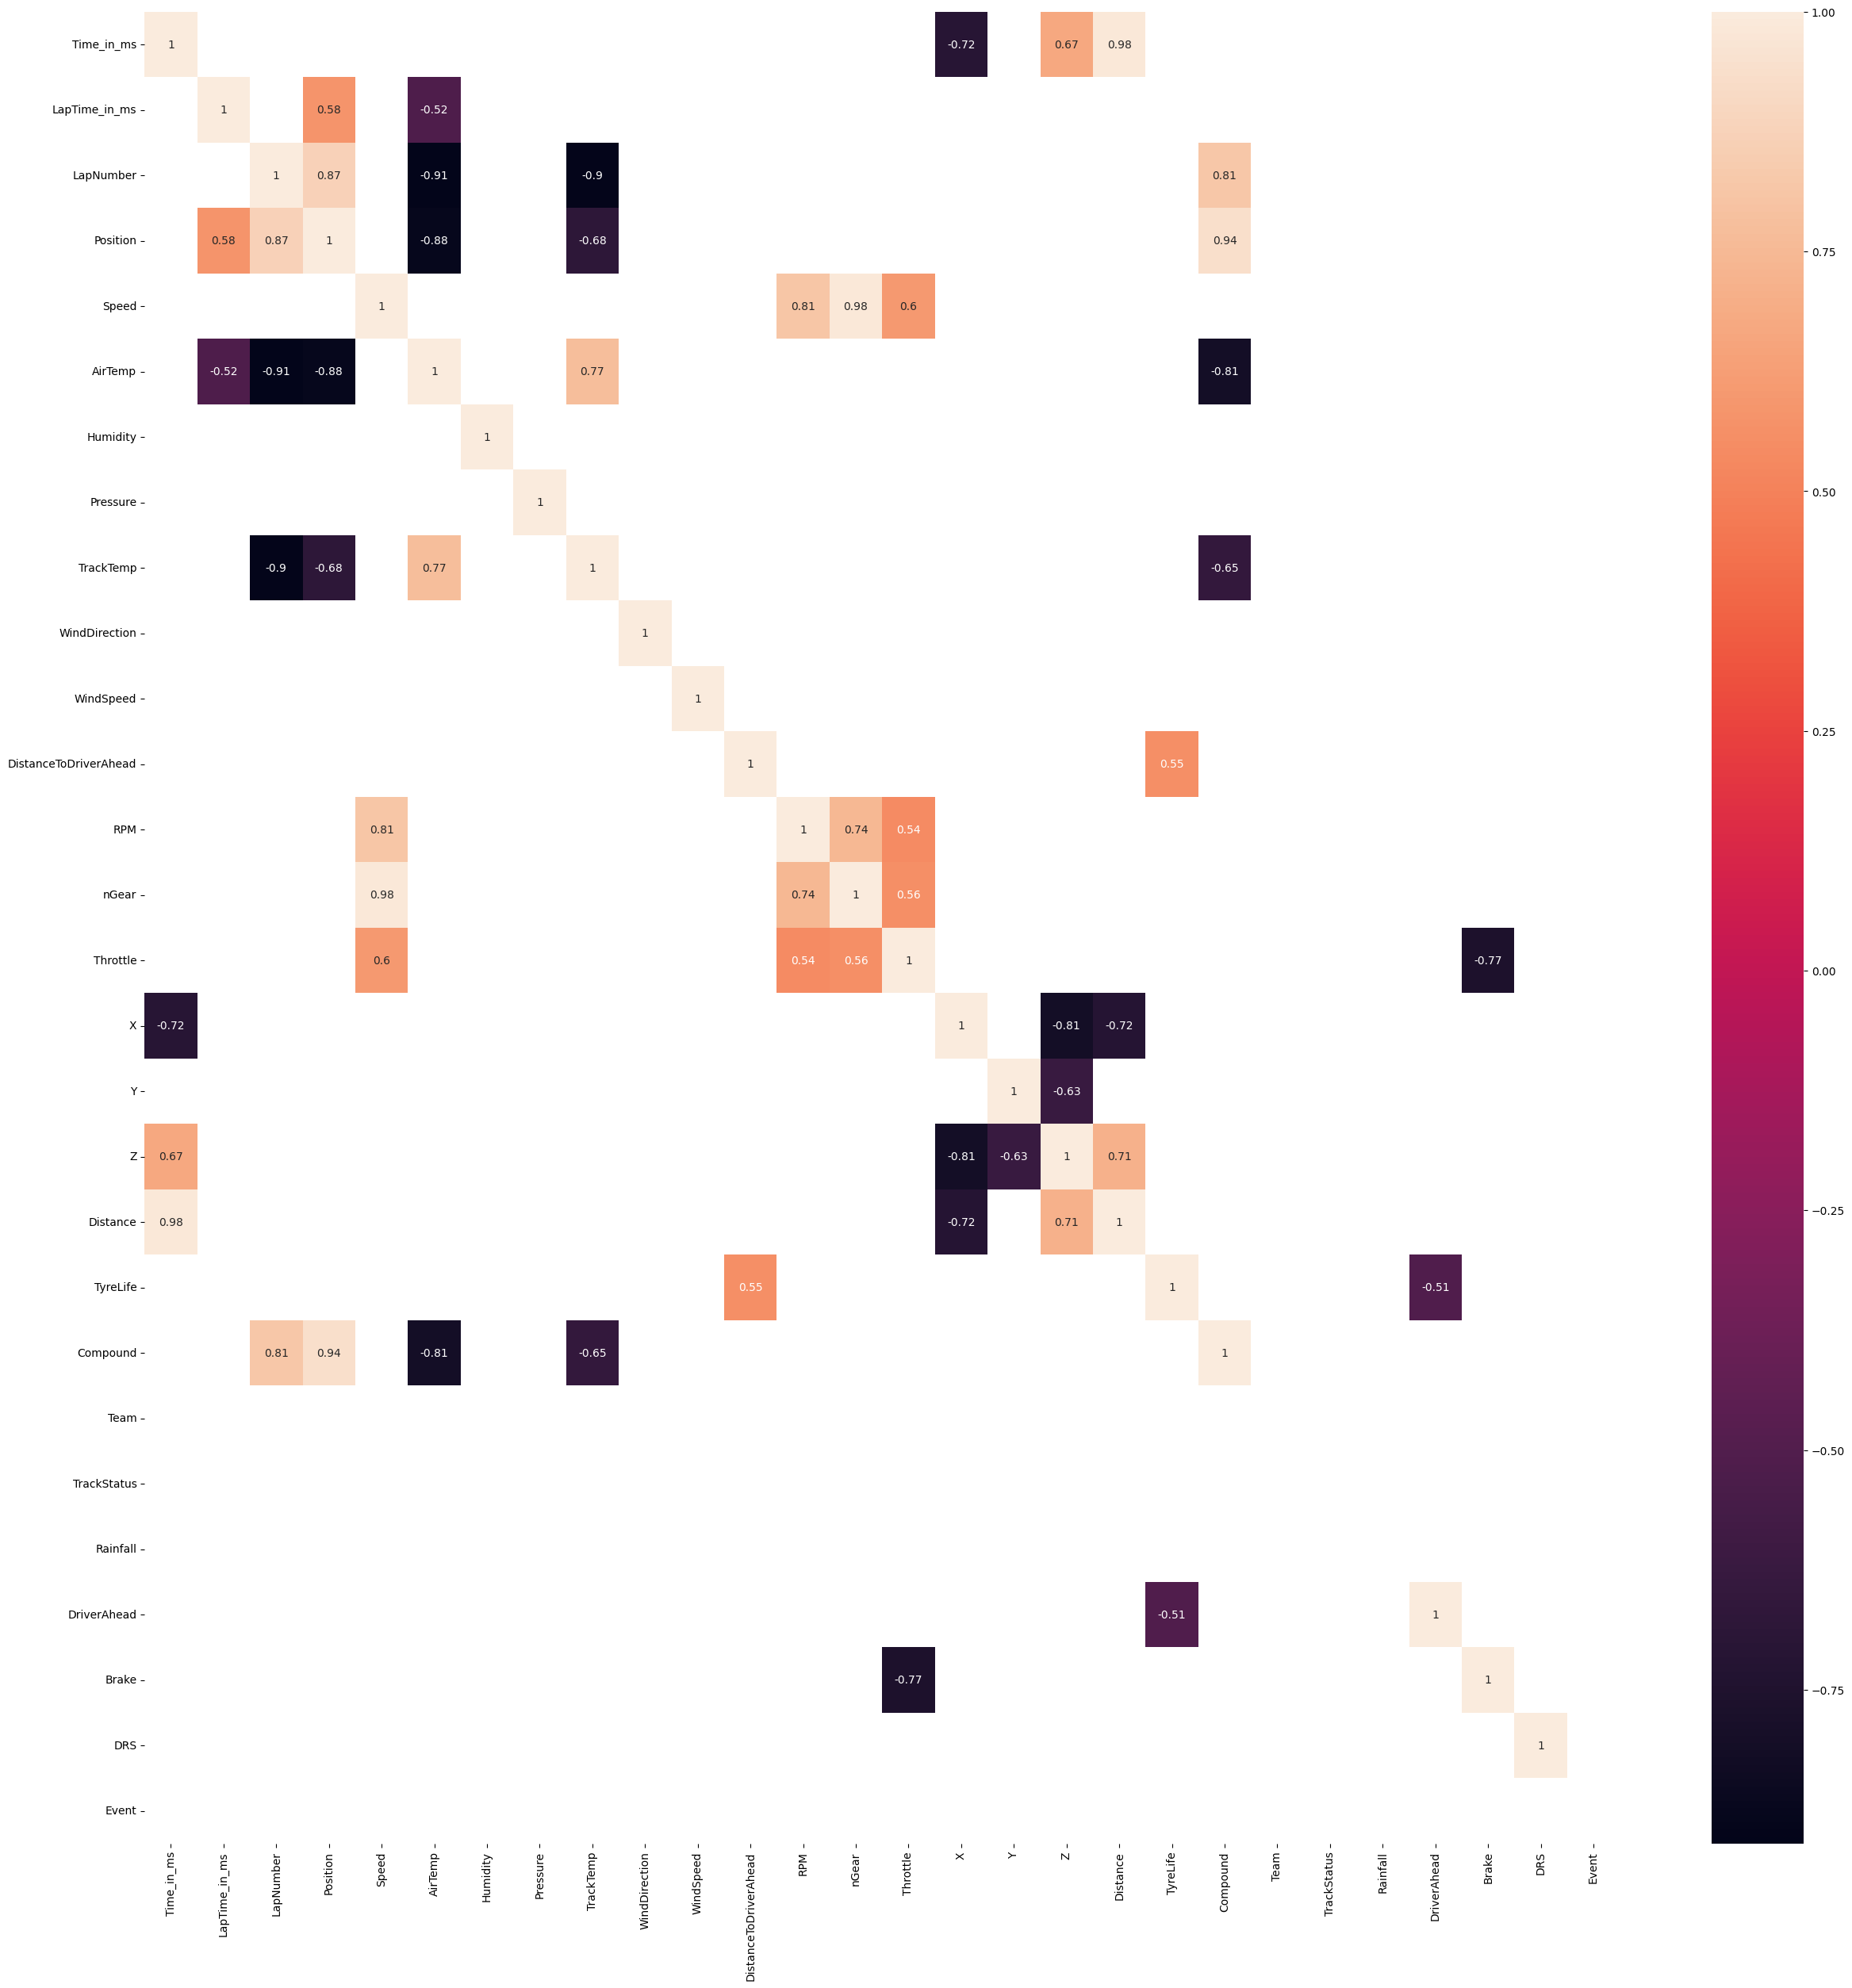

In [9]:
import seaborn as sns
correlation_matrix = pandassato.corr()
#filter the correlation matrix to only show correlations above 0.5 and below -0.5
mask = correlation_matrix >0.5
mask2 = correlation_matrix <-0.5
filtered = correlation_matrix[mask | mask2]
#very big heatmap
plt.figure(figsize=(30, 30))

sns.heatmap(filtered, annot=True,)

In [10]:
len(new_data)

11466

In [11]:
def plot_reconstruction_errors_with_threshold(errors, threshold=None):
    """
    Plots reconstruction errors as a line graph with an optional threshold.

    Parameters:
        errors (np.array): Array of reconstruction errors.
        threshold (float, optional): Threshold for detecting anomalies. Defaults to None.
    """
    plt.figure(figsize=(24, 6))
    plt.plot(errors, label="Reconstruction Errors", color='blue', linewidth=1.5)
    
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold")
    
    plt.xlabel("Sample Index")
    plt.xticks(range(0, len(reconstruction_errors), 300))
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Errors with Threshold")
    
    # Aggiungi legenda una sola volta
    # plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.show()

In [12]:
# threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
threshold = np.percentile(reconstruction_errors, 99.9)

# Visualize errors
# visualize_reconstruction_errors(reconstruction_errors, threshold=threshold)

# Print anomalies
anomalies = reconstruction_errors > threshold
print(f"Total anomalies detected: {np.sum(anomalies)}")

Total anomalies detected: 321


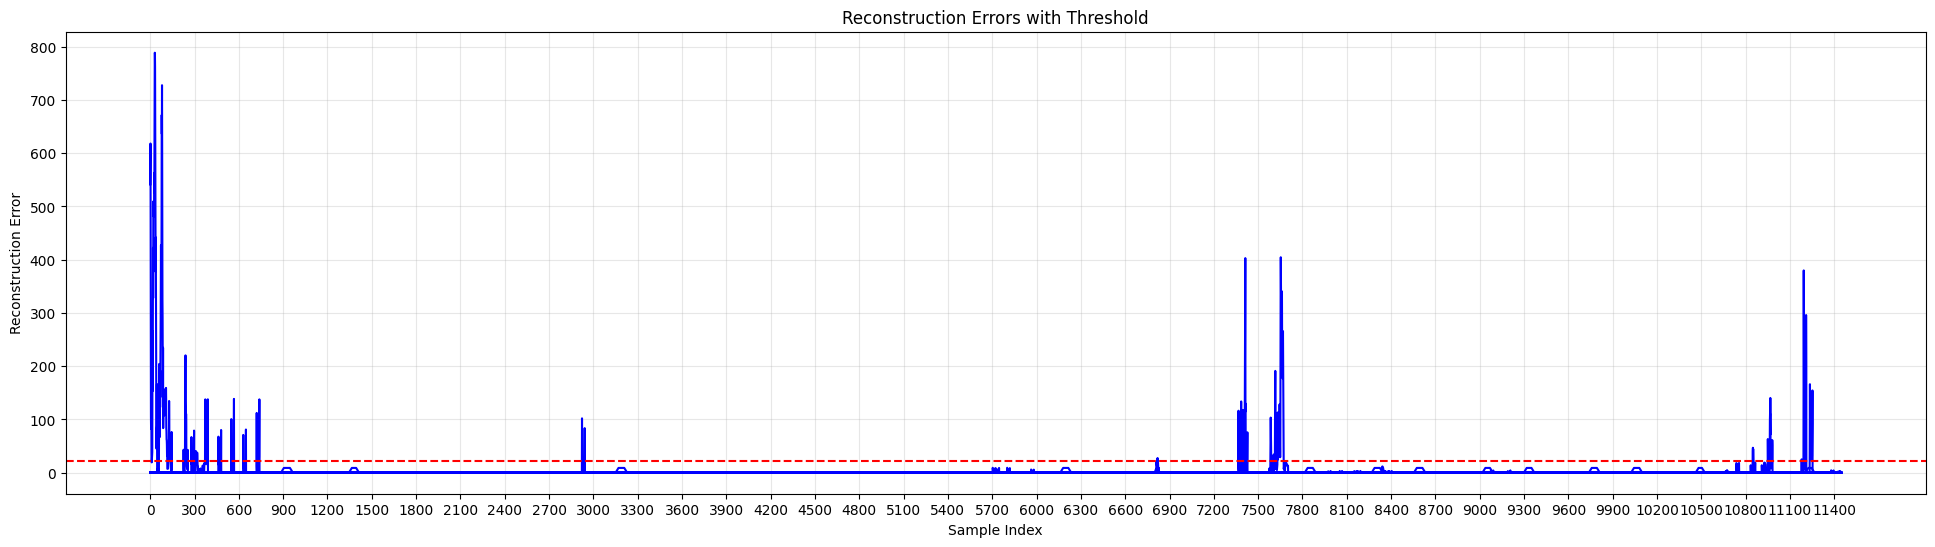

In [13]:
plot_reconstruction_errors_with_threshold(reconstruction_errors, threshold=threshold)

In [14]:
# Find the indexes where anomalies are True
indexes = np.where(anomalies == True)[0]

# Group consecutive True blocks, allowing gaps of up to 5
blocks = []
block = []

for i in range(len(indexes)):
    if not block or indexes[i] <= block[-1] + 5:
        # Start a new block or extend the current one
        block.append(indexes[i])
    else:
        # Close the current block and start a new one
        blocks.append(block)
        block = [indexes[i]]

# Append the last block
if block:
    blocks.append(block)

print(blocks)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115], [124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 144, 145], [226], [236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254], [279, 280], [286, 287], [296, 297, 302], [309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320], [372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382], [388, 389, 390], [462, 463], [469], [479, 480], [549], [565, 566, 567], [630], [647, 648], [721], [737, 738, 739], [2923], [2940, 2941], [6816, 6817, 6818, 6819, 6820, 6821], [7367], [7383, 7384, 7385], [7397], [7409, 7410, 7411, 7412, 7413

In [15]:
len(blocks)

40

In [16]:
minutes_to_exlude = 5 # around first 3 laps
# Exclude first laps
first_lap_sequences = int((minutes_to_exlude * 60 * 1000) / 240)  # (minutes_to_exlude in milliseconds / length of a row)
count = 0
for block in blocks:
    if len(block) > 1:
        if block[0] > first_lap_sequences:
            print(f"Anomaly detected from timestep {block[0]}, with len {len(block)+20}")
            count += 1
print(f"Total anomalies detected: {count}")

Anomaly detected from timestep 2940, with len 22
Anomaly detected from timestep 6816, with len 26
Anomaly detected from timestep 7383, with len 23
Anomaly detected from timestep 7409, with len 27
Anomaly detected from timestep 7425, with len 23
Anomaly detected from timestep 7583, with len 26
Anomaly detected from timestep 7600, with len 22
Anomaly detected from timestep 7609, with len 34
Anomaly detected from timestep 7631, with len 62
Anomaly detected from timestep 10847, with len 25
Anomaly detected from timestep 10950, with len 22
Anomaly detected from timestep 10963, with len 26
Anomaly detected from timestep 10976, with len 25
Anomaly detected from timestep 11192, with len 26
Anomaly detected from timestep 11208, with len 23
Anomaly detected from timestep 11234, with len 39
Total anomalies detected: 16


In [17]:
pandassato[25923:27080]

,Time_in_ms,LapTime_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,DriverAhead,Brake,DRS,Event


In [18]:
# Convert reconstruction errors to a DataFrame
reconstruction_errors_df = pd.DataFrame(reconstruction_errors[2000:], columns=pandassato.columns)

# Calculate the correlation matrix
correlation_with_errors = pandassato[2000:].corrwith(reconstruction_errors_df, axis=0)

# Display the correlation values

print(correlation_with_errors)

Time_in_ms              -0.139337
LapTime_in_ms           -0.046227
LapNumber                0.270781
Position                -0.031951
Speed                   -0.070139
AirTemp                 -0.030414
Humidity                -0.034239
Pressure                 0.016218
TrackTemp               -0.065960
WindDirection            0.027303
WindSpeed                0.060724
DistanceToDriverAhead    0.049575
RPM                     -0.053946
nGear                   -0.069195
Throttle                -0.046467
X                        0.207844
Y                       -0.066146
Z                       -0.132332
Distance                -0.063990
TyreLife                 0.068540
Compound                -0.016874
Team                          NaN
TrackStatus                   NaN
Rainfall                      NaN
DriverAhead             -0.045475
Brake                    0.016221
DRS                     -0.069162
Event                         NaN
dtype: float64
